<h2 align=center>Analyze Worldwide Box Office Data with Seaborn and Python (Part 1)</h2>
<img src="revenue.png">

### Libraries

In [3]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import json
import ast
from urllib.request import urlopen
from PIL import Image

[nltk_data] Downloading package stopwords to /home/rhyme/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Task 1: Data Loading and Exploration

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [5]:
train.head()

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,Keywords,revenue,collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,production_company_United Artists,production_company_Miramax Films,production_company_Village Roadshow Pictures,production_company_Regency Enterprises,production_company_BBC Films,production_company_Dune Entertainment,production_company_Working Title Films,production_company_Fox Searchlight Pictures,production_company_StudioCanal,production_company_Lionsgate,production_company_DreamWorks SKG,production_company_Fox 2000 Pictures,production_company_Summit Entertainment,production_company_Hollywood Pictures,production_company_Orion Pictures,production_company_Amblin Entertainment,production_company_Dimension Films,num_countries,production_country_United States of America,production_country_United Kingdom,production_country_France,production_country_Germany,production_country_Canada,production_country_India,production_country_Italy,production_country_Japan,production_country_Australia,production_country_Russia,production_country_Spain,production_country_China,production_country_Hong Kong,production_country_Ireland,production_country_Belgium,production_country_South Korea,production_country_Mexico,production_country_Sweden,production_country_New Zealand,production_country_Netherlands,production_country_Czech Republic,production_country_Denmark,production_country_Brazil,production_country_Luxembourg,production_country_South Africa,num_languages,language_English,language_Français,language_Español,language_Deutsch,language_Pусский,language_Italiano,language_日本語,language_普通话,language_हिन्दी,language_,language_Português,language_العربية,language_한국어/조선말,language_广州话 / 廣州話,language_தமிழ்,language_Polski,language_Magyar,language_Latin,language_svenska,language_ภาษาไทย,language_Český,language_עִבְרִית,language_ελληνικά,language_Türkçe,language_Dansk,language_Nederlands,language_فارسی,language_Tiếng Việt,language_اردو,language_Română,num_cast,cast_name_Samuel L. Jackson,cast_name_Robert De Niro,cast_name_Morgan Freeman,cast_name_J.K. Simmons,cast_name_Bruce Willis,cast_name_Liam Neeson,cast_name_Susan Sarandon,cast_name_Bruce McGill,cast_name_John Turturro,cast_name_Forest Whitaker,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone,genders_0_cast,genders_1_cast,genders_2_cast,cast_character_,cast_character_Himself,cast_character_Herself,cast_character_Dancer,cast_character_Additional Voices (voice),cast_character_Doctor,cast_character_Reporter,cast_character_Waitress,cast_character_Nurse,cast_character_Bartender,cast_character_Jack,cast_character_Debutante,cast_character_Security Guard,cast_character_Paul,cast_character_Frank,num_crew,crew_name_Avy Kaufman,crew_name_Robert Rodriguez,crew_name_Deborah Aquila,crew_name_James Newton Howard,crew_name_Mary Vernieu,crew_name_Steven Spielberg,crew_name_Luc Besson,crew_name_Jerry Goldsmith,crew_name_Francine Maisler,crew_name_Tricia Wood,crew_name_James Horner,crew_name_Kerry Barden,crew_name_Bob Weinstein,crew_name_Harvey Weinstein,crew_name_Janet Hirshenson,genders_0_crew,genders_1_crew,genders_2_crew,jobs_

### Task 2: Visualizing the Target Distribution

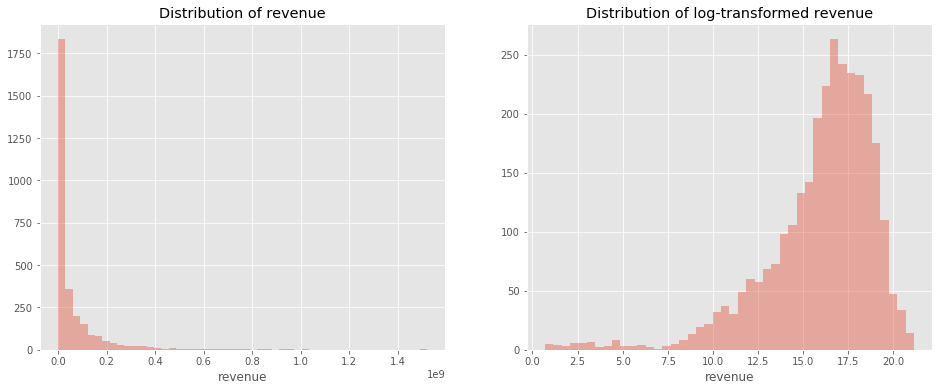

In [6]:
fig, ax = plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
sns.distplot(train['revenue'], kde=False);
plt.title('Distribution of revenue');
plt.subplot(1,2,2)
sns.distplot(np.log1p(train['revenue']), kde = False);
plt.title('Distribution of log-transformed revenue');


In [7]:
train['log_revenue'] = np.log1p(train['revenue'])

### Task 3: Relationship between Film Revenue and Budget

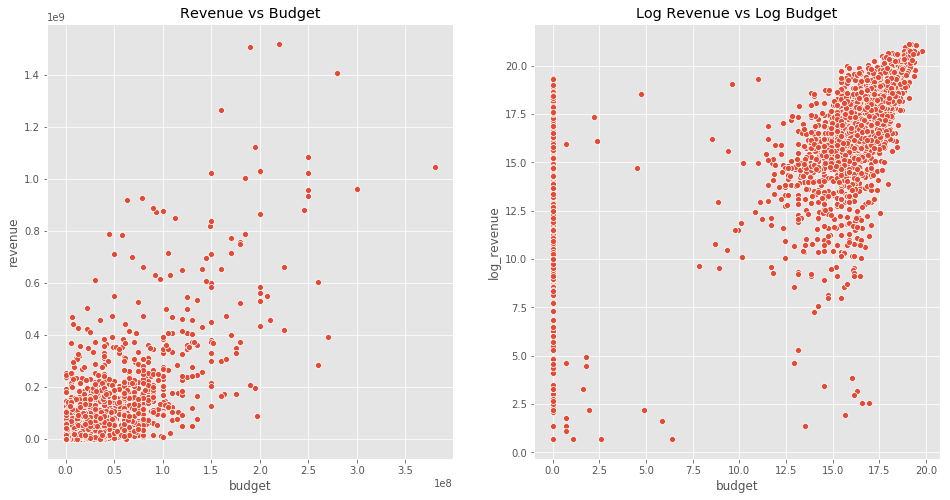

In [8]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.scatterplot(train['budget'], train['revenue'])
plt.title('Revenue vs Budget');
plt.subplot(1,2,2)
sns.scatterplot(np.log1p(train['budget']),train['log_revenue'])
plt.title('Log Revenue vs Log Budget');

In [9]:
train['log_budget'] = np.log1p(train['budget'])
test['log_budget'] = np.log1p(test['budget'])

### Task 4: Does having an Official Homepage Affect Revenue?

In [11]:
train['homepage'].value_counts().head(10)

http://www.transformersmovie.com/                  4
http://www.thehobbit.com/                          2
http://www.lordoftherings.net/                     2
http://snowdenfilm.com/                            1
http://www.brokenlizard.com/                       1
http://katyn.netino.pl/en/                         1
http://rec4apocalipsis.com/                        1
http://www.themortalinstrumentsmovie.com/          1
http://www.thenextthreedaysmovie.com/index.html    1
http://www.painandgainmovie.com/                   1
Name: homepage, dtype: int64

In [12]:
train['has_homepage'] = 0
train.loc[train['homepage'].isnull()==False, 'has_homepage'] = 1
test['has_homepage'] = 0
test.loc[test['homepage'].isnull()==False, 'has_homepage']=1

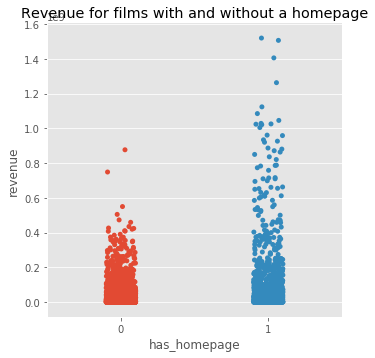

In [13]:
sns.catplot(x='has_homepage', y='revenue', data=train);
plt.title('Revenue for films with and without a homepage');

### Task 5: Distribution of Languages in Film

In [14]:
language_data = train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]

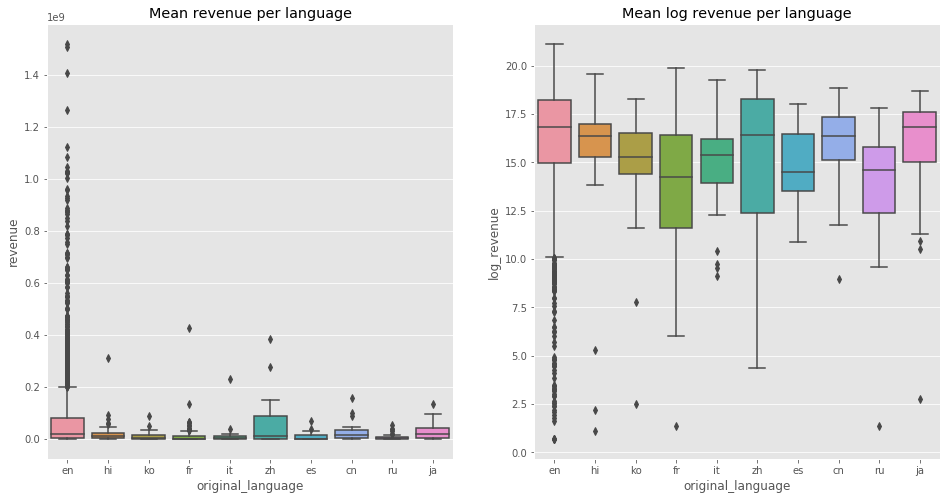

In [15]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.boxplot(x='original_language', y='revenue',data=language_data)
plt.title('Mean revenue per language');
plt.subplot(1,2,2)
sns.boxplot(x='original_language', y='log_revenue',data=language_data)
plt.title('Mean log revenue per language');

### Task 6: Frequent Words in Film Titles and Descriptions

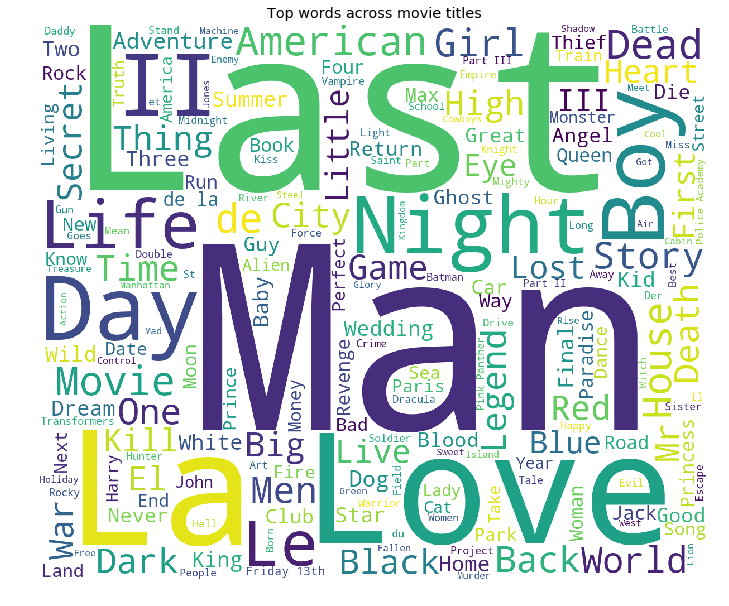

In [16]:
plt.figure(figsize=(12,12))
text = ' '.join(train['original_title'].values)
wordcloud = WordCloud(max_font_size = None,
                     background_color='white',
                     width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words across movie titles')
plt.axis('off')
plt.show()

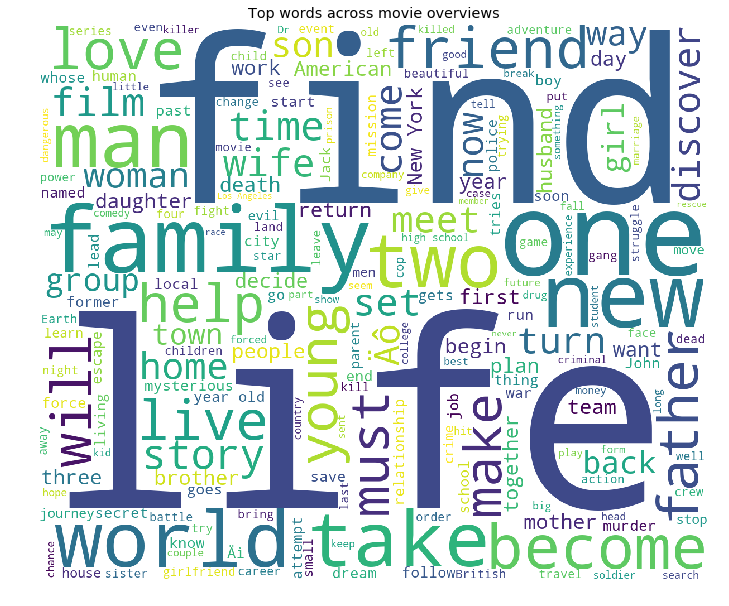

In [17]:
plt.figure(figsize=(12,12))
text = ' '.join(train['overview'].fillna('').values)
wordcloud = WordCloud(max_font_size = None,
                     background_color='white',
                     width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words across movie overviews')
plt.axis('off')
plt.show()

### Task 7: Do Film Descriptions Impact Revenue?

In [18]:
import eli5
from sklearn.linear_model import LinearRegression

In [19]:
vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 2),
    min_df=5
)
overview_text = vectorizer.fit_transform(train['overview'].fillna(''))
linreg = LinearRegression()
linreg.fit(overview_text, train['log_revenue'])
eli5.show_weights(linreg, vec=vectorizer, top=20, feature_filter=lambda x: x!='<BIAS>')
